In [1]:
import numpy as np
import math

In [2]:
# weird constants? ew
# should probably find nicer way to use these vals

HEIGHT = 1
WIDTH = 2

LEFT = 0
RIGHT = 1
TOP = 2
BOTTOM = 3

In [3]:
def get_padding(pad_str, 
                filter_shape, 
                in_shape, 
                stride_h=1, 
                stride_w=1, 
                dilate_h=1, 
                dilate_w=1
               ):
    
    padding = [0,0,0,0]

    if pad_str == 'SAME':
        dilated_width = (filter_shape[WIDTH] - 1) * dilate_w + 1
        dilated_height = (filter_shape[HEIGHT] - 1) * dilate_h + 1

        out_w = math.ceil(in_shape[WIDTH] / stride_w)
        out_h = math.ceil(in_shape[HEIGHT] / stride_h)

        padding[LEFT] = math.floor(dilated_width / 2)
        padding[RIGHT] = out_w * stride_w - (stride_w - 1) + math.floor(filter_shape[WIDTH] / 2) - in_shape[WIDTH]
        padding[TOP] = math.floor(dilated_height / 2)
        padding[BOTTOM] = out_h * stride_h - (stride_h - 1) + math.floor(filter_shape[HEIGHT] / 2) - in_shape[HEIGHT]                

    return padding
       

In [4]:
def get_final_shape(in_shape, 
                    filter_shape, 
                    pad_str='VALID', 
                    stride_h=1, 
                    stride_w=1, 
                    dilate_h=1, 
                    dilate_w=1
                   ):
    w = 0
    h = 0

    if pad_str == 'SAME':
        w = math.ceil(in_shape[WIDTH] / stride_w)
        h = math.ceil(in_shape[HEIGHT] / stride_h)
        
    else:
        dilated_rad_h = math.floor(((filter_shape[HEIGHT] - 1) * dilate_h + 1) / 2)
        dilated_rad_w = math.floor(((filter_shape[WIDTH] - 1) * dilate_w + 1) / 2)
        
        w = math.floor((in_shape[WIDTH] - dilated_rad_w - 1) / stride_w)
        h = math.floor((in_shape[HEIGHT] - dilated_rad_h - 1) / stride_h)

    return (h, w)


In [5]:
def im2col(input_data,
           filter_shape, 
           stride_h=1, 
           stride_w=1,
           dilate_h=1, 
           dilate_w=1,
           pad=[0,0,0,0] # left right top bottom
          ):
    
    filter_h = (filter_shape[HEIGHT]-1) * dilate_h + 1
    filter_w = (filter_shape[WIDTH]-1) * dilate_w + 1
    channels = input_data.shape[-1]
    

    def get_pixel(row, col):
        if 0 <= row < input_data.shape[HEIGHT] and 0 <= col < input_data.shape[WIDTH]:
            return input_data[0, row, col, :]
        return np.zeros(channels)

    pixels_per_col = filter_shape[1] * filter_shape[2] * filter_shape[3]
    cols = np.empty((pixels_per_col, 0))
    
    
    # loop over image
    for r in range(-pad[TOP], input_data.shape[HEIGHT] - filter_h + 1 + pad[BOTTOM], stride_h):
        for c in range(-pad[LEFT], input_data.shape[WIDTH] - filter_w + 1 + pad[RIGHT], stride_w):
            
            # loop over kernel
            new_col = []
            for row in range(r, r + filter_h, dilate_h):
                for col in range(c, c + filter_w, dilate_w):
                    
                    for val in get_pixel(row, col):
                        new_col.append(val)
            new_col = np.array(new_col).reshape((-1, 1))
            cols = np.append(cols, new_col, axis=-1)
                    
    return cols

# CONV2D

In [6]:
def conv2d(input_data, 
           filter_weights,
           bias_weights=None,
           stride_h=1, 
           stride_w=1, 
           dilate_h=1, 
           dilate_w=1, 
           pad_str='VALID', 
          ):
    
    padding = get_padding(pad_str, filter_weights.shape, input_data.shape, stride_h, stride_w, dilate_h, dilate_w)

    # display stuff and make sure it's correct
    print('********DOING CONV2D********')
    print('input shape:', input_data.shape)
    print('filter shape:', filter_weights.shape)
    print('stride_h:', stride_h)
    print('stride_w:', stride_w)
    print('dilate_h_factor:', dilate_h)
    print('dilate_w_factor:', dilate_w)
    print('padding:', pad_str, padding)

    my_im2col = im2col(input_data, 
                       filter_weights.shape, 
                       stride_h=stride_h,
                       stride_w=stride_w, 
                       dilate_h=dilate_h, 
                       dilate_w=dilate_w, 
                       pad=padding
                      )

    out = (filter_weights.reshape((filter_weights.shape[0], -1)) @ my_im2col).transpose()
    shape = get_final_shape(input_data.shape, filter_weights.shape, pad_str, stride_h=stride_h, stride_w=stride_w)
    
    out = out.reshape((input_data.shape[0], shape[0], shape[1], filter_weights.shape[0]))

    print('output shape:', out.shape)
    if bias_weights is not None:
        out = np.add(out, bias_weights)
    return out
               

# DEPTHWISE CONV

In [7]:
def depthwise_conv(input_data, 
                   filter_weights, 
                   bias_weights=None, 
                   stride_h=1, 
                   stride_w=1, 
                   dilate_h=1, 
                   dilate_w=1, 
                   pad_str='VALID', 
                   depth_mult=1
                  ):
    
    new_channel_shape = get_final_shape(input_data.shape, filter_weights.shape, pad_str, stride_h=stride_h, stride_w=stride_w)
    padding = get_padding(pad_str, filter_weights.shape, input_data.shape, stride_h, stride_w, dilate_h, dilate_w)

    # display stuff and make sure it's correct
    print('*****DOING DEPTHWISE CONV*****')
    print('input shape:', input_data.shape)
    print('filter shape:', filter_weights.shape)
    print('stride_h:', stride_h)
    print('stride_w:', stride_w)
    print('dilate_h_factor:', dilate_h)
    print('dilate_w_factor:', dilate_w)
    print('padding:', pad_str, padding)
    print('depth mult:', depth_mult)
    print('new channel shape:', new_channel_shape)
    
    
    out = []
    num_channels = input_data.shape[-1]
    
    dilated_kernel_h = filter_weights.shape[HEIGHT] * dilate_h
    dilated_kernel_w = filter_weights.shape[WIDTH] * dilate_w

    def get_val(row, col, channel):
        if 0 <= row < input_data.shape[HEIGHT] and 0 <= col < input_data.shape[WIDTH]:
            return input_data[0, row, col, channel]
        else:
            return 0
        
    for channel_idx in range(num_channels):
        
        # loop over channel
        channel = input_data[:,:,:,channel_idx]
        new_channel = []
        for row in range(-padding[LEFT], input_data.shape[HEIGHT] - dilated_kernel_h + 1 + padding[RIGHT], stride_h):
            for col in range(-padding[TOP], input_data.shape[WIDTH] - dilated_kernel_w + 1 + padding[BOTTOM], stride_w):
                
                val = 0
                # loop over kernel
                for r in range(0, dilated_kernel_h, dilate_h):
                    for c in range(0, dilated_kernel_w, dilate_w):
                        val += get_val(row + r, col + c, channel_idx) * filter_weights[0, r, c, channel_idx]
                new_channel.append(val)
                
        new_channel = np.array(new_channel).reshape(new_channel_shape)
        out.append(new_channel)
                        
        
    out = np.stack(out, axis=-1)
    out = out.reshape((1, out.shape[0], out.shape[1], out.shape[2]))
    print('final shape:', out.shape)
    
    if bias_weights is not None:
        out = np.add(out, bias_weights)
    return out


# AVG POOL

In [8]:
def avg_pool(input_data, 
             filter_shape, 
             stride_h=1, 
             stride_w=1, 
             pad_str='VALID', 
            ):
    
    f_weight = 1 / np.prod(filter_shape)
    filter_shape = (1, filter_shape[0], filter_shape[1], input_data.shape[-1])
    
    new_channel_shape = get_final_shape(input_data.shape, filter_shape, pad_str, stride_h=stride_h, stride_w=stride_w)
    padding = get_padding(pad_str, filter_shape, input_data.shape, stride_h, stride_w)

    # display stuff and make sure it's correct
    print('********DOING AVG POOL********')
    print('input shape:', input_data.shape)
    print('filter shape:', filter_shape)
    print('stride_h:', stride_h)
    print('stride_w:', stride_w)
    print('padding:', pad_str, padding)
    print('new channel shape:', new_channel_shape)
    
    
    out = []
    num_channels = input_data.shape[-1]

    def get_val(row, col, channel):
        if 0 <= row < input_data.shape[HEIGHT] and 0 <= col < input_data.shape[WIDTH]:
            return input_data[0, row, col, channel]
        else:
            return 0
        
    for channel_idx in range(num_channels):
        
        # loop over channel
        channel = input_data[:,:,:,channel_idx]
        new_channel = []
        for row in range(-padding[LEFT], input_data.shape[HEIGHT] - filter_shape[HEIGHT] + 1 + padding[RIGHT], stride_h):
            for col in range(-padding[TOP], input_data.shape[WIDTH] - filter_shape[WIDTH] + 1 + padding[BOTTOM], stride_w):
                
                val = 0
                # loop over kernel
                for r in range(filter_shape[HEIGHT]):
                    for c in range(filter_shape[WIDTH]):
                        val += get_val(row + r, col + c, channel_idx) * f_weight
                new_channel.append(val)
                
        new_channel = np.array(new_channel).reshape(new_channel_shape)
        out.append(new_channel)
                        
        
    out = np.stack(out, axis=-1)
    out = out.reshape((1, out.shape[0], out.shape[1], out.shape[2]))
    print('final shape:', out.shape)
    return out
    
    

# MAX POOL

In [9]:
def max_pool(input_data, 
             filter_shape, 
             stride_h=1, 
             stride_w=1, 
             pad_str='VALID', 
            ):
    
    filter_shape = (1, filter_shape[0], filter_shape[1], input_data.shape[-1])
    
    new_channel_shape = get_final_shape(input_data.shape, filter_shape, pad_str, stride_h=stride_h, stride_w=stride_w)
    padding = get_padding(pad_str, filter_shape, input_data.shape, stride_h, stride_w)

    # display stuff and make sure it's correct
    print('********DOING MAX POOL********')
    print('input shape:', input_data.shape)
    print('filter shape:', filter_shape)
    print('stride_h:', stride_h)
    print('stride_w:', stride_w)
    print('padding:', pad_str, padding)
    print('new channel shape:', new_channel_shape)
    
    
    out = []
    num_channels = input_data.shape[-1]

    def get_val(row, col, channel):
        if 0 <= row < input_data.shape[HEIGHT] and 0 <= col < input_data.shape[WIDTH]:
            return input_data[0, row, col, channel]
        else:
            return 0
        
    for channel_idx in range(num_channels):
        
        # loop over channel
        channel = input_data[:,:,:,channel_idx]
        new_channel = []
        for row in range(-padding[LEFT], input_data.shape[HEIGHT] - filter_shape[HEIGHT] + 1 + padding[RIGHT], stride_h):
            for col in range(-padding[TOP], input_data.shape[WIDTH] - filter_shape[WIDTH] + 1 + padding[BOTTOM], stride_w):
                
                # append max
                kernel = input_data[:,row:row+filter_shape[HEIGHT],col:col+filter_shape[WIDTH],channel_idx]
                val = np.amax(kernel)
                
                new_channel.append(val)
                
        new_channel = np.array(new_channel).reshape(new_channel_shape)
        out.append(new_channel)
                        
        
    out = np.stack(out, axis=-1)
    out = out.reshape((1, out.shape[0], out.shape[1], out.shape[2]))
    print('final shape:', out.shape)
    return out
    
    

# SQUEEZE

In [10]:
def squeeze(input_data, squeeze_dims):
    print('********DOING SQUEEZE*********')
    print('squeeze dims:', squeeze_dims)
    print('og shape:', input_data.shape)
    
    out = input_data
    for dim in sorted(squeeze_dims)[::-1]:
        out = np.squeeze(out, axis=dim)
    
    print('final shape:', out.shape)
    return out

# CONCAT

In [11]:
def concat(inputs, axis):
    print('********DOING CONCAT**********')
    print('input shapes:')
    for data in inputs:
        print('\t', data.shape)
    print('axis:', axis)
    
    out = np.concatenate(inputs, axis)
    print('final shape:', out.shape)
    
    return out

In [12]:
def activation(tensor, activation_str):
    if activation_str == 'NONE':
        return tensor
    elif activation_str == 'RELU':
        return relu(tensor)
    elif activation_str == 'RELU6':
        return relu6(tensor)
    else:
        raise NotImplementedError()

def relu(tensor):
    return np.minimum(np.maximum(tensor, 0), tensor)

def relu6(tensor):
    return np.minimum(np.maximum(tensor, 0), 6)

def softmax(input_data, beta=1):
    print('*******DOING SOFTMAX********')
    print('beta:', beta)
    
    x = input_data
    x = x - x.max(axis=None, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=None, keepdims=True)


## Load ImageNet labels

In [13]:
def load_imagenet_labels():
    with open('imagenet_labels.txt') as f:
        lines = f.readlines()

        labels = []
        for line in lines:
            s = line.split(':')[1]
            s = s.replace('\n', '')
            s = s.replace("'", '')
            s = s[1:-1]
            labels.append(s)

    return labels

labels = load_imagenet_labels()

## Mobilenet

In [14]:
import flatbuffers as fb
from tflite import * 

In [15]:
# load model stuf
buf = open('mobilenet_v1_1.0_224.tflite', 'rb').read()
buf = bytearray(buf)

mobilenet = Model.GetRootAsModel(buf, 0)

sub = mobilenet.Subgraphs(0)

In [16]:
def get_correct_option_type(op):
    op_type = op.BuiltinOptionsType()
    
    if op_type == BuiltinOptions.Conv2DOptions:
        return Conv2DOptions()
    
    elif op_type == BuiltinOptions.DepthwiseConv2DOptions:
        return DepthwiseConv2DOptions()
    
    elif op_type == BuiltinOptions.Pool2DOptions:
        return Pool2DOptions()
    
    elif op_type == BuiltinOptions.SqueezeOptions:
        return SqueezeOptions()
    
    elif op_type == BuiltinOptions.SoftmaxOptions:
        return SoftmaxOptions()
    
    return None


In [17]:
def do_layer(layer, input_data):
    print('layer', layer)
    op = sub.Operators(layer)
    out = 0
    
    filters_idx = op.Inputs(1)
    bias_idx = op.Inputs(2)
    padding_to_str = {Padding.SAME: 'SAME', Padding.VALID: 'VALID'}
    activation_to_str = {ActivationFunctionType.NONE: 'NONE', ActivationFunctionType.RELU: 'RELU', ActivationFunctionType.RELU_N1_TO_1: 'RELU_N1_TO_1', ActivationFunctionType.RELU6: 'RELU6', ActivationFunctionType.TANH: 'TANH', ActivationFunctionType.SIGN_BIT: 'SIGN_BIT'}

    op_type = op.BuiltinOptionsType()
    options = get_correct_option_type(op) 
        
    union = op.BuiltinOptions()
    options.Init(union.Bytes, union.Pos)

    # CONV2D
    if op_type == BuiltinOptions.Conv2DOptions:

        pad_str = padding_to_str[options.Padding()]
        activation_str = activation_to_str[options.FusedActivationFunction()]

        stride_h = options.StrideH()
        stride_w = options.StrideW()

        filter_shape = tuple(sub.Tensors(filters_idx).ShapeAsNumpy())
        bias_weights = np.frombuffer(mobilenet.Buffers(sub.Tensors(bias_idx).Buffer()).DataAsNumpy(), dtype=np.float32)
        filter_weights = np.frombuffer(mobilenet.Buffers(sub.Tensors(filters_idx).Buffer()).DataAsNumpy(), dtype=np.float32).reshape(filter_shape)

        dilate_h = options.DilationHFactor()
        dilate_w = options.DilationWFactor()

        out = conv2d(input_data,
                     filter_weights,
                     bias_weights, 
                     stride_h=stride_h, 
                     stride_w=stride_w, 
                     dilate_h=dilate_h, 
                     dilate_w=dilate_w, 
                     pad_str=pad_str
                    )
                
        print('activation:', activation_str)
        out = activation(out, activation_str)
        
    #DEPTHWISE
    elif op_type == BuiltinOptions.DepthwiseConv2DOptions:


        pad_str = padding_to_str[options.Padding()]
        activation_str = activation_to_str[options.FusedActivationFunction()]

        stride_h = options.StrideH()
        stride_w = options.StrideW()

        filter_shape = tuple(sub.Tensors(filters_idx).ShapeAsNumpy())
        bias_weights = np.frombuffer(mobilenet.Buffers(sub.Tensors(bias_idx).Buffer()).DataAsNumpy(), dtype=np.float32)
        filter_weights = np.frombuffer(mobilenet.Buffers(sub.Tensors(filters_idx).Buffer()).DataAsNumpy(), dtype=np.float32).reshape(filter_shape)

        depth_mult = options.DepthMultiplier()
        dilate_h = options.DilationHFactor()
        dilate_w = options.DilationWFactor()

        out = depthwise_conv(input_data,
                             filter_weights,
                             bias_weights, 
                             stride_h=stride_h, 
                             stride_w=stride_w, 
                             dilate_h=dilate_h, 
                             dilate_w=dilate_w, 
                             pad_str=pad_str,
                             depth_mult=depth_mult
                            )
        
        print('activation:', activation_str)
        out = activation(out, activation_str)
        
    # POOL
    elif op_type == BuiltinOptions.Pool2DOptions:

        pad_str = padding_to_str[options.Padding()]
        activation_str = activation_to_str[options.FusedActivationFunction()]

        stride_h = options.StrideH()
        stride_w = options.StrideW()

        f_shape = (options.FilterHeight(), options.FilterWidth())

        out = avg_pool(input_data, 
                       f_shape, 
                       stride_h=stride_h, 
                       stride_w=stride_w, 
                       pad_str=pad_str, 
                      )

        print('activation:', activation_str)
        out = activation(out, activation_str)
        
    # SQUEEZE
    elif op_type == BuiltinOptions.SqueezeOptions:
        dims = options.SqueezeDimsAsNumpy()
        
        out = squeeze(input_data,
                     dims)
        
    # SOFTMAX
    elif op_type == BuiltinOptions.SoftmaxOptions:
        out = softmax(input_data)
        
    else:
        print('!!!!!!!NOT IMPLEMENTED!!!!!!!!')
        raise NotImplementedError()

        
    print('*' * 30)
    print()
    return out

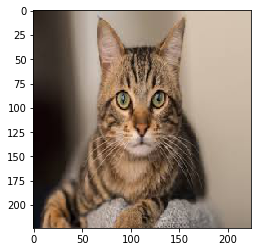

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


img = Image.open('pics/cat.jpg')
img = img.resize((224,224))
plt.imshow(img)

In [19]:
data = np.array(img).reshape((1,224,224,3)) / 255

num_layers = sub.OperatorsLength()
for i in range(num_layers):
    data = do_layer(i, data)

print(data.shape)

layer 0
********DOING CONV2D********
input shape: (1, 224, 224, 3)
filter shape: (32, 3, 3, 3)
stride_h: 2
stride_w: 2
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [1, 0, 1, 0]
output shape: (1, 112, 112, 32)
activation: RELU6
******************************

layer 1
*****DOING DEPTHWISE CONV*****
input shape: (1, 112, 112, 32)
filter shape: (1, 3, 3, 32)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [1, 1, 1, 1]
depth mult: 1
new channel shape: (112, 112)
final shape: (1, 112, 112, 32)
activation: RELU6
******************************

layer 2
********DOING CONV2D********
input shape: (1, 112, 112, 32)
filter shape: (64, 1, 1, 32)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
output shape: (1, 112, 112, 64)
activation: RELU6
******************************

layer 3
*****DOING DEPTHWISE CONV*****
input shape: (1, 112, 112, 64)
filter shape: (1, 3, 3, 64)
stride_h: 2
stride_w: 2
dilate_h_factor: 1
dilate_w_fact

In [20]:
sorted_idxs = np.argsort(data.reshape(-1))[::-1] - 1

print('index\tprob\tlabel')
print('*' * 30)
for idx in sorted_idxs[:5]:
    prob = data[0, idx + 1] * 100
    print('%i\t%.2f%%\t%s' % (idx, prob, labels[idx]))

index	prob	label
******************************
282	59.42%	tiger cat
285	28.65%	Egyptian cat
281	9.19%	tabby, tabby cat
782	0.75%	screen, CRT screen
453	0.31%	bookcase
